# PUBG data analysis - EDA

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(1234)
import time
import gc

#### ML
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

- **playerId** - Integer ID to identify a player.
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.
- **assists** - Number of enemy players this player damaged that were killed by teammates.
- **boosts** - Number of boost items used.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked.
- **headshotKills** - Number of enemy players killed with headshots.
- **heals** - Number of healing items used.
- **killPlace** - Ranking in match of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **matchDuration** - How long a match takes.
- **matchType** - Type of a match: squad, duo, solo, squad-fpp, duo-fpp, solo-fpp.
- **revives** - Number of times this player revived teammates.
- **rideDistance** - Total distance traveled in vehicles measured in meters.
- **roadKills** - Number of kills while in a vehicle.
- **swimDistance** - Total distance traveled by swimming measured in meters.
- **teamKills** - Number of times this player killed a teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot measured in meters.
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- **winPlace** - The final ranking in a match.

In [76]:
# read data
data = pd.read_csv('data.csv')
data_new = pd.read_csv('data_1203.csv')

In [77]:
# convert winPlace to winPlace percentage
# Revert the percentage, 1.0 represent No.1 , 0 represent ranked the last one
data['winPlacePerc'] = data.groupby(data['matchId'])['winPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
data = data.drop(columns=['winPlace'])
data['winPlacePerc'].fillna(0,inplace = True)

In [78]:
# similar to winPlace, convert killPlace to killPalce percentage
data['killPlacePerc'] = data.groupby(data['matchId'])['killPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
data = data.drop(columns=['killPlace'])
data['killPlacePerc'].fillna(0,inplace = True)

In [79]:
data.head(3).transpose()

,0,1,2
playerId,account.84a80903746146a6a031917e09d8726b,account.5514ef172fc94ace81da76239ef14bb1,account.33e009e03a914f16a4e55e6e37c050cd
matchId,0570548f-e758-4320-bbf8-6aa9c959e835,0570548f-e758-4320-bbf8-6aa9c959e835,0570548f-e758-4320-bbf8-6aa9c959e835
assists,0,0,0
boosts,1,0,1
damageDealt,100,122.394,96.555
DBNOs,1,0,0
headshotKills,0,0,0
heals,3,0,0
kills,1,0,0
killStreaks,1,0,0


## Exploratory Data Analysis
### 1. Match Overview

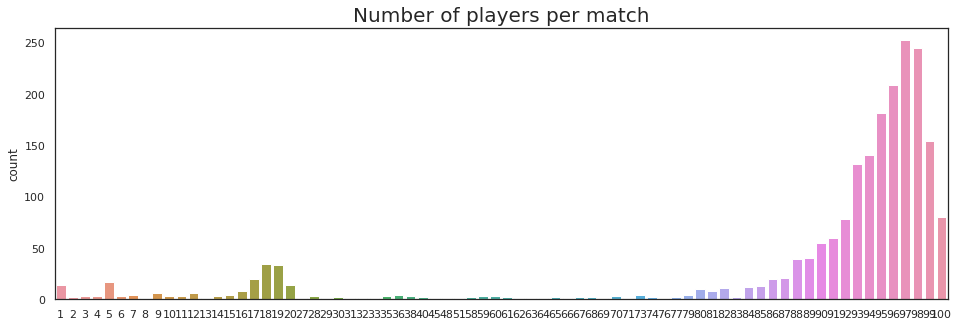

In [9]:
num_players_match = data.groupby(data['matchId'])['playerId'].count().tolist()
plt.figure(figsize = (16,5))
sns.set_style('white')
p = sns.countplot(num_players_match)
p.set_title('Number of players per match', fontsize=20)
plt.show()

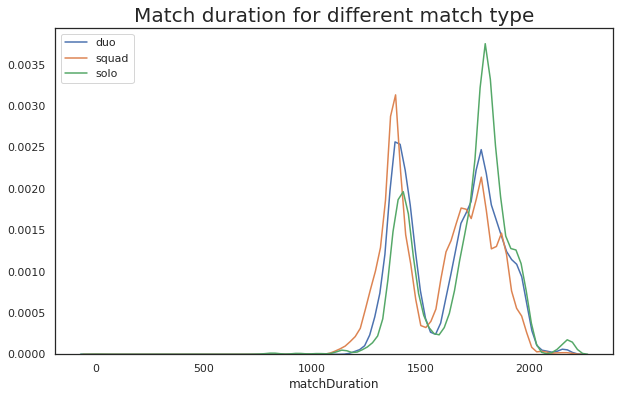

In [21]:
plt.figure(figsize=(10,6))
sns.distplot(data.loc[(data['matchType']=='duo')|(data['matchType']=='duo-fpp')]['matchDuration'],label='duo',hist=False)
sns.distplot(data.loc[(data['matchType']=='squad')|(data['matchType']=='squad-fpp')]['matchDuration'],label='squad',hist=False)
sns.distplot(data.loc[(data['matchType']=='solo')|(data['matchType']=='solo-fpp')]['matchDuration'],label='solo',hist=False)
plt.legend(loc='upper left')
plt.title('Match duration for different match type', fontsize=20)
plt.show()

### 2. Player behavior and win place
#### 2.1 Kill = win?

In [82]:
sns.set()

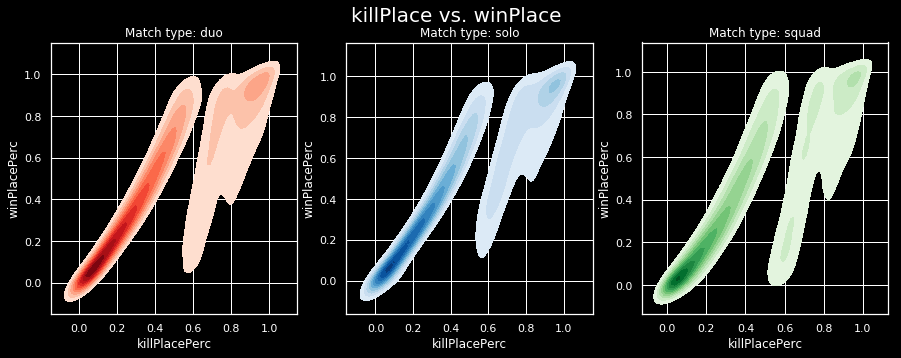

In [93]:
f,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5),facecolor='black')
for i in range(3):
    ax[i].set_facecolor('black')
    ax[i].set_xlabel(xlabel='Kill Place',color="white")
    ax[i].tick_params(axis='x', colors='white')
    ax[i].set_ylabel(ylabel='Win Place Precentage',color="white")
    ax[i].tick_params(axis='y', colors='white')

sns.kdeplot(data.loc[(data['matchType']=='duo')|(data['matchType']=='duo-fpp')]['killPlacePerc'],
                      data.loc[(data['matchType']=='duo')|(data['matchType']=='duo-fpp')]['winPlacePerc'],
                      cmap='Reds', shade=True,shade_lowest=False,ax=ax[0]).set_title('Match type: duo',color='white')

sns.kdeplot(data.loc[(data['matchType']=='solo')|(data['matchType']=='solo-fpp')]['killPlacePerc'],
                      data.loc[(data['matchType']=='solo')|(data['matchType']=='solo-fpp')]['winPlacePerc'],
                      cmap='Blues', shade=True,shade_lowest=False,ax=ax[1]).set_title('Match type: solo',color='white')

sns.kdeplot(data.loc[(data['matchType']=='squad')|(data['matchType']=='squad-fpp')]['killPlacePerc'],
                      data.loc[(data['matchType']=='squad')|(data['matchType']=='squad-fpp')]['winPlacePerc'],
                      cmap='Greens', shade=True,shade_lowest=False,ax=ax[2]).set_title('Match type: squad',color='white')
plt.suptitle('killPlace vs. winPlace',fontsize=20,color='white')
plt.show()

#### 2.2 kills

In [47]:
print('number of kills 50% percentile is: ' + str(data['kills'].quantile(0.5)))
print('number of kills 75% percentile is: ' + str(data['kills'].quantile(0.75)))
print('number of kills 90% percentile is: ' + str(data['kills'].quantile(0.9)))
print('number of kills 95% percentile is: ' + str(data['kills'].quantile(0.95)))
print('number of kills 99% percentile is: ' + str(data['kills'].quantile(0.99)))

number of kills 50% percentile is: 0.0
number of kills 75% percentile is: 1.0
number of kills 90% percentile is: 3.0
number of kills 95% percentile is: 4.0
number of kills 99% percentile is: 7.0


Let's group players based on number of kills: 0 kills, 1-3 kills, 4-7 kill, 7+ kills

In [27]:
data.loc[data['matchType'] == 'duo','matchType_combine'] = 'duo'
data.loc[data['matchType'] == 'duo-fpp','matchType_combine'] = 'duo'
data.loc[data['matchType'] == 'solo','matchType_combine'] = 'solo'
data.loc[data['matchType'] == 'solo-fpp','matchType_combine'] = 'solo'
data.loc[data['matchType'] == 'squad','matchType_combine'] = 'squad'
data.loc[data['matchType'] == 'squad-fpp','matchType_combine'] = 'squad'

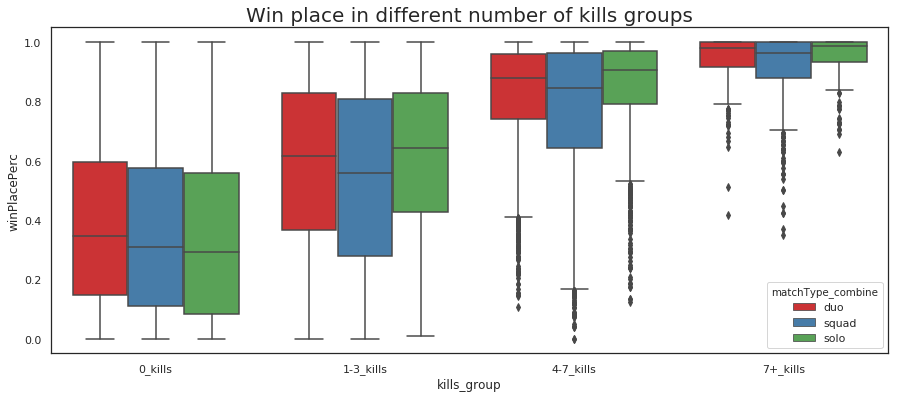

In [70]:
data['kills_group'] = pd.cut(data['kills'], [-1, 0, 3, 7, 40], labels=['0_kills','1-3_kills', '4-7_kills', '7+_kills'])
plt.figure(figsize=(15,6))
sns.boxplot(x=data["kills_group"], y=data["winPlacePerc"],hue=data['matchType_combine'],
           palette=sns.color_palette("Set1"))
plt.title('Win place in different number of kills groups', fontsize=20)
plt.show()

#### 2.3 Transportation

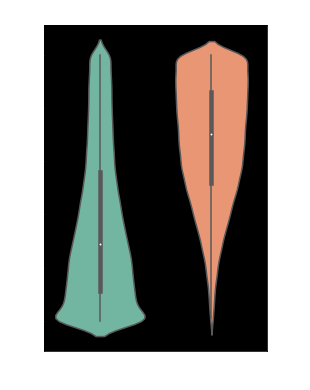

In [21]:
data['drive_group'] = pd.cut(data['rideDistance'], [-1, 0, 50000], labels=['No dirve','Had drives'])

fig,ax = plt.subplots(figsize =(4,6))
ax.set_facecolor('black')
ax.set_xlabel(xlabel='Kill Place',color="white")
ax.tick_params(axis='x', colors='white')
ax.set_ylabel(ylabel='Win Place Precentage',color="white")
ax.tick_params(axis='y', colors='white')

sns.violinplot(x=data["drive_group"], y=data["winPlacePerc"],palette=sns.color_palette("Set2"))
plt.title('Win Place Percentage with Drive or not', fontsize=15,color='white')
plt.show()

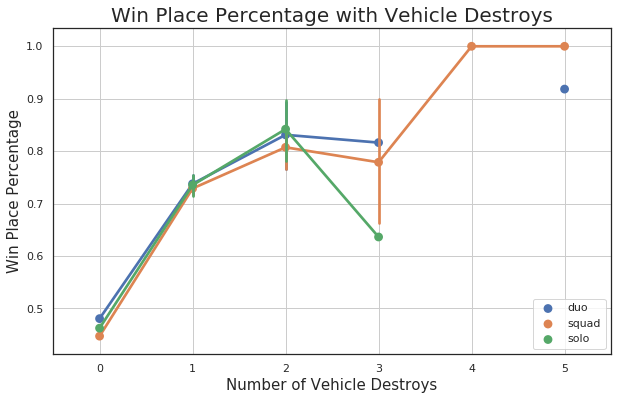

In [97]:
f,ax1 = plt.subplots(figsize =(10,6))
sns.pointplot(x=data['vehicleDestroys'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Vehicle Destroys',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### 2.4 Heals and boost

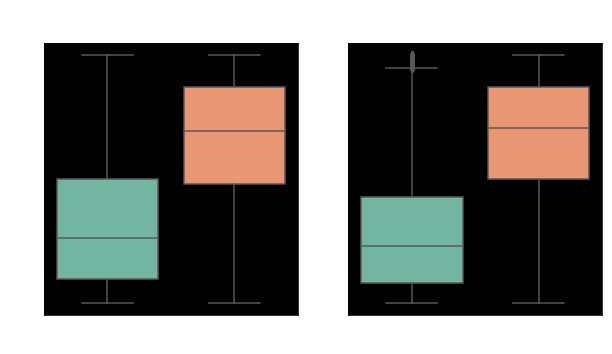

In [25]:
data['heal_group'] = pd.cut(data['heals'], [-1, 0, 50000], labels=['No heals','Used heals'])
data['boost_group'] = pd.cut(data['boosts'], [-1, 0, 50000], labels=['No boosts','Used boosts'])

f,ax = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
for i in range(2):
    ax[i].set_facecolor('black')
    ax[i].set_xlabel(xlabel='Kill Place',color="white")
    ax[i].tick_params(axis='x', colors='white')
    ax[i].set_ylabel(ylabel='Win Place Precentage',color="white")
    ax[i].tick_params(axis='y', colors='white')
sns.boxplot(x=data["heal_group"], y=data["winPlacePerc"],palette=sns.color_palette("Set2"),ax=ax[0]).set_title('Usage of Heal',color='white')
sns.boxplot(x=data["boost_group"], y=data["winPlacePerc"],palette=sns.color_palette("Set2"),ax=ax[1]).set_title('Usage of Boost',color='white')
plt.suptitle('Win Place Percentage with Recover Items Usage', fontsize=20,color='white')
plt.show()

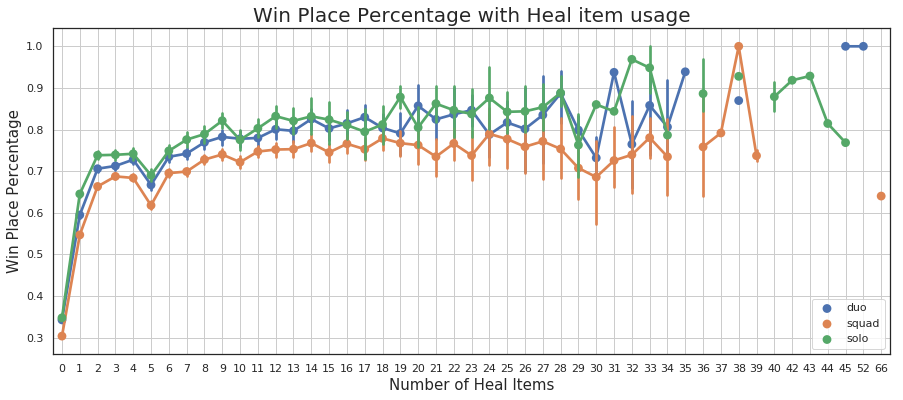

In [115]:
f,ax1 = plt.subplots(figsize =(15,6))
sns.pointplot(x=data['heals'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Heal Items',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Heal item usage',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

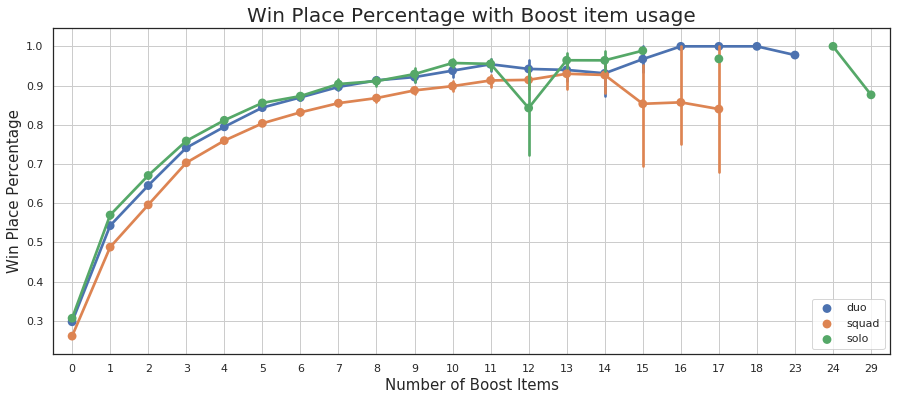

In [119]:
f,ax1 = plt.subplots(figsize =(15,6))
sns.pointplot(x=data['boosts'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Boost Items',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Boost item usage',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

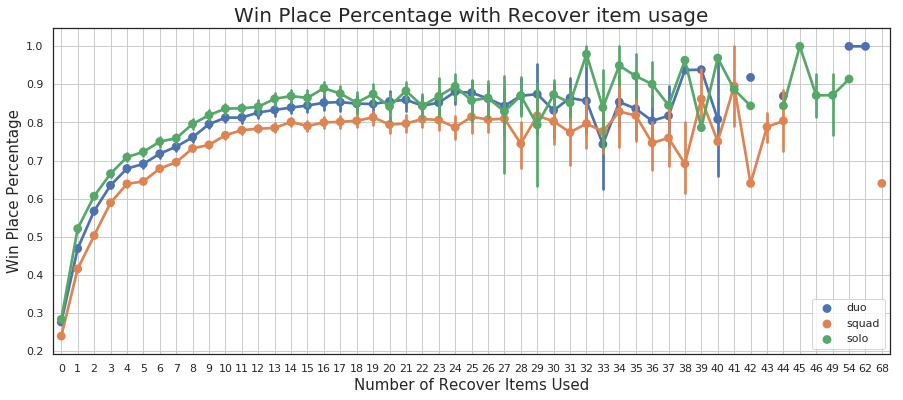

In [117]:
data['items'] = data['heals']+data['boosts']
f,ax1 = plt.subplots(figsize =(15,6))
sns.pointplot(x=data['items'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8)
plt.xlabel('Number of Recover Items Used',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Recover item usage',fontsize = 20)
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### 2.5 Teamwork

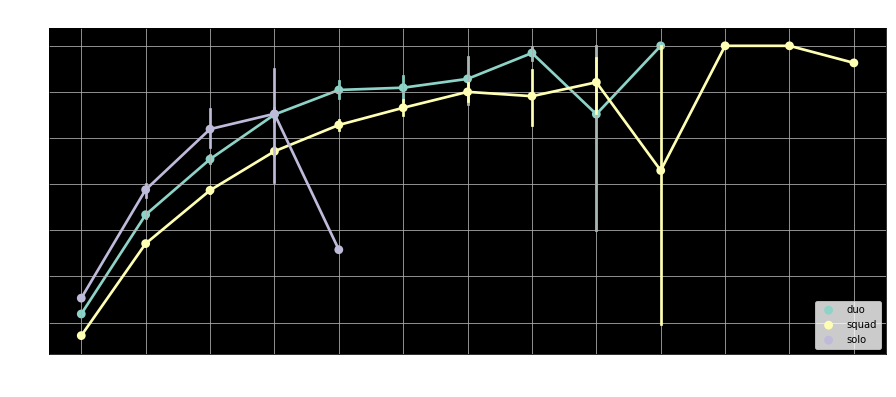

In [31]:
data['teamwork'] = data['assists']+data['revives']
f,ax = plt.subplots(figsize =(15,6))
ax.set_facecolor('black')
ax.set_xlabel(xlabel='Kill Place',color="white")
ax.tick_params(axis='x', colors='white')
ax.set_ylabel(ylabel='Win Place Precentage',color="white")
ax.tick_params(axis='y', colors='white')

sns.pointplot(x=data['teamwork'],y=data['winPlacePerc'], hue=data['matchType_combine'],alpha=0.8,palette = 'Set3')
plt.xlabel('Assists + Revives',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Teamwork',fontsize = 20,color='white')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### 2.6 Weapon

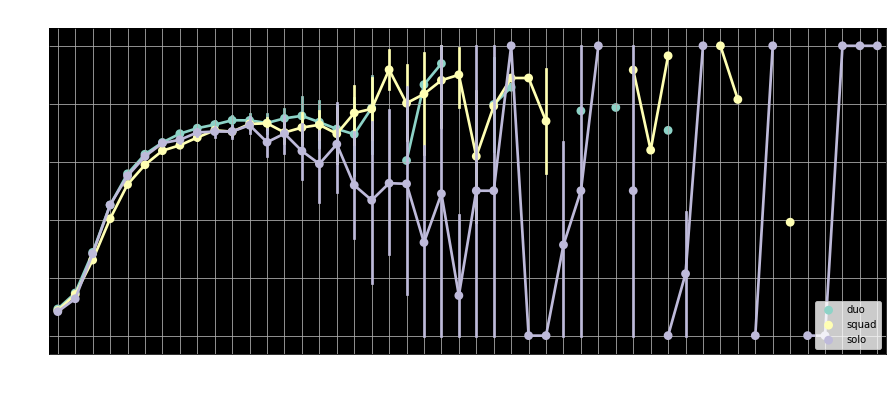

In [15]:
f,ax = plt.subplots(figsize =(15,6))
ax.set_facecolor('black')
ax.set_xlabel(xlabel='Kill Place',color="white")
ax.tick_params(axis='x', colors='white')
ax.set_ylabel(ylabel='Win Place Precentage',color="white")
ax.tick_params(axis='y', colors='white')
sns.pointplot(x=data['weaponsAcquired'],y=data['winPlacePerc'], hue=data['matchType_combine'],
              alpha=0.8, palette = 'Set3')
plt.xlabel('Weapon Acquired',fontsize = 15)
plt.ylabel('Win Place Percentage',fontsize = 15)
plt.title('Win Place Percentage with Weapon Acquired',fontsize = 20,color='white')
plt.legend(loc='lower right')
plt.grid()
plt.show()

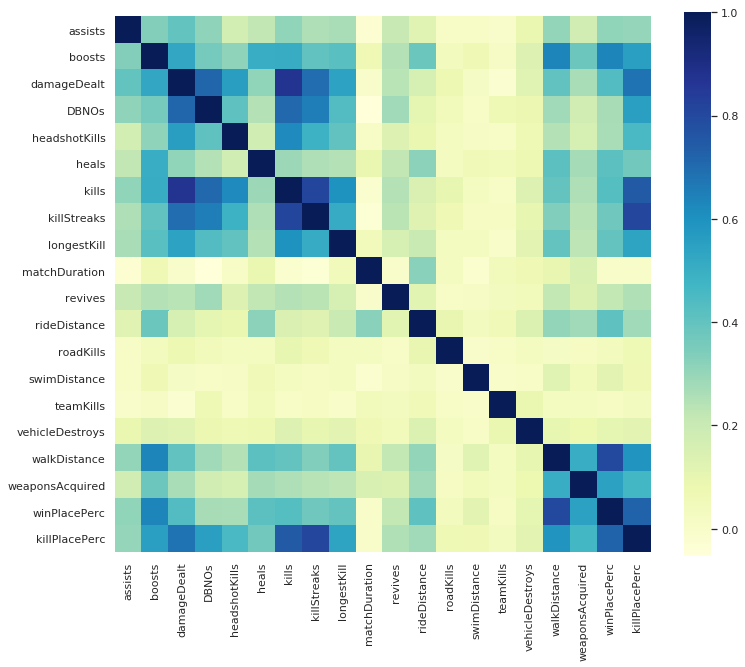

In [135]:
plt.figure(figsize = (12,10))
sns.heatmap(data.corr(),fmt= '.1f',square=True,)
plt.show()

In [26]:
# read data
data = pd.read_csv('data.csv')

In [27]:
# convert winPlace to winPlace percentage
# Revert the percentage, 1.0 represent No.1 , 0 represent ranked the last one
data['winPlacePerc'] = data.groupby(data['matchId'])['winPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
data = data.drop(columns=['winPlace'])
data['winPlacePerc'].fillna(0,inplace = True)

In [28]:
# similar to winPlace, convert killPlace to killPalce percentage
data['killPlacePerc'] = data.groupby(data['matchId'])['killPlace'].transform(lambda x: (x.max()-x)/(x.max()-x.min()))
data = data.drop(columns=['killPlace'])
data['killPlacePerc'].fillna(0,inplace = True)

# Feature Engineering

From the DEA above, we have a rough idea about what variables might contribute the players final ranking. In general, winPlance heavily rely on **usage of items, transportation and weapons** in a match. Therefore, we can generate some useful features around them.

## 1. Usage of items

In [29]:
# total items used
data['item'] = data['heals']+data['boosts']

## 2. Transportation

In [30]:
# total distance
data['distance'] = data['walkDistance'] + data['rideDistance']+data['swimDistance']

Since healing and boosting items both can help players to move and thus stay out of the circle, we create some features to capture relationship between them

In [31]:
data['walkDistance_heals'] = data['walkDistance']/(data['heals']+1) # to avoid inifity
data['walkDistance_boosts'] = data['walkDistance']/(data['boosts']+1)

## 3. Weapons
Weapons are used for kills, let's create features about weapons and kills

In [32]:
data['weapon_kills'] = data['weaponsAcquired']/(data['kills']+1)

## 4.Teamwork
We noticed that some top-ranking players even didn't make a kill during one match, which seems wierd. The reason behind this is that the winplace is determined by group. Even if a player killed at the begining of the game, he/she still can get a high rank if his/her teammates survived till the end. Therefore, we might want create some feature about teamwork

In [33]:
data['teamwork'] = data['assists']+data['revives']

# Modeling
## 1. Data preprocessing
To apply the LGB model, we need to transform variable types to float/int.

In [34]:
def transfrom_data(column):
    le = LabelEncoder()
    le.fit(list(data[col]))
    data[col] = le.transform(data[col])
    return data

In [35]:
for col in data.columns:
    if data[col].dtypes == "object":
        data = transfrom_data(col)

## 2. Split data

In [36]:
def random_sample(data, num_match):
    match_ids = data['matchId'].unique().tolist()
    random_matches = random.sample(match_ids, num_match)
    sample_data = data.loc[data['matchId'].isin(random_matches)]
    return sample_data

In [37]:
# we need to split train and test sets by match
def split_data(data, split_percent = 0.2):
    match_ids = data['matchId'].unique().tolist()
    train_matches = random.sample(match_ids, int(len(match_ids)*(1-split_percent)))
    
    train = data.loc[data['matchId'].isin(train_matches)]
    test = data.loc[~data['matchId'].isin(train_matches)]
    
    train = train.drop(columns=['playerId','matchId','matchDuration'])
    test = test.drop(columns=['playerId','matchId','matchDuration'])
    
    return train, test

In [38]:
train,test = split_data(data)

In [41]:
train.head(3).transpose()

,0,1,2
assists,0.000000,0.000000,0.000000
boosts,1.000000,0.000000,1.000000
damageDealt,100.000000,122.394394,96.555000
DBNOs,1.000000,0.000000,0.000000
headshotKills,0.000000,0.000000,0.000000
heals,3.000000,0.000000,0.000000
kills,1.000000,0.000000,0.000000
killStreaks,1.000000,0.000000,0.000000
longestKill,3.997975,0.000000,0.000000
matchType,0.000000,0.000000,0.000000


## 3. Training using CV

In [42]:
params = {
                    'objective':'regression',
                    'boosting_type':'gbdt',#traditional Gradient Boosting Decision Tree, aliases:
                    'metric':'rmse',
                    'learning_rate':0.005,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'early_stopping_rounds':250,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'max_bin':255,
                    'seed': 1234,
                } 

In [43]:
class LGB():
    def __init__(self, train, test, num_cv, parameter):
        self.train = train
        self.test = test
        self.num_cv = num_cv
        self.parameter = parameter
    
    def split(self):
        self.train_y = self.train['winPlacePerc']
        self.train_x = self.train.drop(['winPlacePerc'],axis=1)
        self.test_y = self.test['winPlacePerc']
        self.test_x = self.test.drop(['winPlacePerc'],axis=1)
        
    def cross_validation(self):
        folds = KFold(n_splits=self.num_cv, shuffle=True, random_state=1234)
        columns = self.train_x.columns
        self.splits = folds.split(self.train_x, self.train_y)
    
    def training(self):
        self.split()
        self.cross_validation()
        
        feature_importances = pd.DataFrame()
        feature_importances['feature'] = self.train_x.columns

        y_pred_test_vectors = np.zeros(self.test_x.shape[0])
        y_pred_valid_vectors = np.zeros(self.train_y.shape[0])
        
        train_mse = 0
        valid_mse = 0
        
        for fold_n, (train_index, valid_index) in enumerate(self.splits):
            x_train = self.train_x.iloc[train_index] 
            x_valid = self.train_x.iloc[valid_index]
            y_train = self.train_y.iloc[train_index] 
            y_valid = self.train_y.iloc[valid_index]
            
            dtrain = lgb.Dataset(x_train, label=y_train)
            dvalid = lgb.Dataset(x_valid, label=y_valid)

            model = lgb.train(self.parameter, dtrain, 10000, valid_sets = [dtrain, dvalid],verbose_eval=False)
            
            feature_importances['fold_{}'.format(fold_n + 1)] = model.feature_importance()

            # Predict and put OOF predicted data into holdout position
            y_pred_train = model.predict(x_train)
            y_pred_valid = model.predict(x_valid)
            y_pred_valid_vectors[valid_index] = y_pred_valid

            # Averaging mse
            train_mse += mean_squared_error(y_train, y_pred_train) / self.num_cv
            valid_mse += mean_squared_error(y_valid, y_pred_valid) / self.num_cv

            # Averaging predicting value
            y_pred_test_vectors += model.predict(self.test_x) / self.num_cv

            del x_train, x_valid, y_train, y_valid

            #gabage collector
            gc.collect()
        return model, train_mse, valid_mse, y_pred_test_vectors,feature_importances

In [47]:
dataset = random_sample(data,2007)
train_set, test_set = split_data(dataset)
model_lgb = LGB(train_set, test_set, 5, params)
model, train_mse, valid_mse, y_pred_test_vectors,fe = model_lgb.training()


In [44]:
dataset = random_sample(data,2007)
train_set, test_set = split_data(dataset)

In [172]:
train_mse

0.001289136435727555

In [173]:
valid_mse

0.005925161987906993

In [171]:
mean_squared_error(test_set['winPlacePerc'], y_pred_test_vectors)

0.007947307343654673

In [175]:
model.save_model('model.txt')

In [176]:
reload_model = lgb.Booster(model_file='model.txt') 

In [177]:
reload_model==model

False

In [178]:
reload_model

In [179]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
json_model = pickle.load(open('model.pkl', 'rb'))

In [181]:
json_model

In [186]:
b=model.predict(test_set)

In [187]:
a= json_model.predict(test_set)

In [188]:
a==b

array([ True,  True,  True, ...,  True,  True,  True])

In [165]:
fe.to_csv('feature_importance.csv')

Text(0.5, 1.0, 'TOP 10 feature importance over 5 folds average')

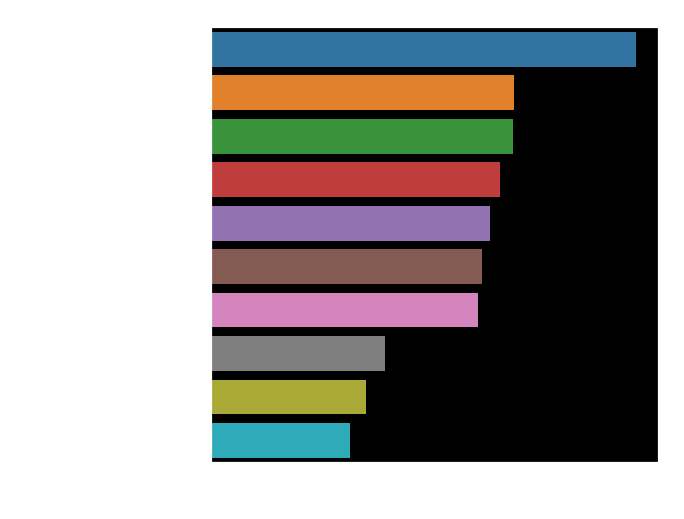

In [73]:
fe['average'] = fe.mean(axis = 1)
plt.figure(figsize=(8, 8))
with sns.axes_style({'axes.facecolor': 'black',
                     'figure.facecolor': 'black',
                     'axes.labelcolor': 'white',
                     'axes.edgecolor': 'white',
                     'xtick.color':'white',
                     'ytick.color':'white'}):
    sns.barplot(data=fe.sort_values(by='average', ascending=False).head(10), x='average', y='feature')
    sns.set_context("notebook",font_scale=1.5, rc={"lines.linewidth": 2.5})
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.title('TOP 10 feature importance over 5 folds average', fontsize=20, color='white')

In [33]:
match_nums = [100*i for i in range(1,20)] + [2007]
match_nums

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2007]

In [37]:
train_mse = [0.0001987780412582635,
 0.00011798773031438735,
 8.299642629422373e-05,
 9.050229634429163e-05,
 0.00013031142600981326,
 0.00019209702059798126,
 0.00027694425851707824,
 0.00034389247759616926,
 0.0004232291008502843,
 0.0005262444006411488,
 0.0006168994607365517,
 0.0007153291414476659,
 0.0008219902387584307,
 0.0008979065808535297,
 0.0009567478424566895,
 0.001084584411535419,
 0.001189803351899421,
 0.0012573096156498196,
 0.001371112195200651,
 0.0014521411119297815]

In [38]:
train_mse_new = [train_mse[i]/match_nums[i] for i in range(20)]
train_mse_new

[1.987780412582635e-06,
 5.899386515719367e-07,
 2.766547543140791e-07,
 2.2625574086072907e-07,
 2.6062285201962653e-07,
 3.2016170099663543e-07,
 3.9563465502439746e-07,
 4.2986559699521155e-07,
 4.7025455650031587e-07,
 5.262444006411487e-07,
 5.608176915786834e-07,
 5.961076178730549e-07,
 6.323001836603313e-07,
 6.413618434668069e-07,
 6.378318949711263e-07,
 6.778652572096369e-07,
 6.998843246467182e-07,
 6.985053420276776e-07,
 7.216379974740268e-07,
 7.235381723616251e-07]

In [34]:
valid_mse = [0.007686608231562801,
 0.0065021850060915515,
 0.006789659082712554,
 0.00661355839218233,
 0.006168059323403572,
 0.006198894910961247,
 0.006501552548905337,
 0.006005856064727275,
 0.006219722446019139,
 0.006596446622103145,
 0.006500991966838773,
 0.006304043238232087,
 0.0065596244451827145,
 0.00647346153504203,
 0.006226758837011587,
 0.0063699001267699664,
 0.006425108939130298,
 0.006374341996018975,
 0.006582457144972759,
 0.006444834964541654]


In [35]:
valid_mse_new = [valid_mse[i]/match_nums[i] for i in range(20)]
valid_mse_new

[7.6866082315628e-05,
 3.2510925030457755e-05,
 2.2632196942375178e-05,
 1.6533895980455826e-05,
 1.2336118646807145e-05,
 1.0331491518268745e-05,
 9.28793221272191e-06,
 7.507320080909094e-06,
 6.910802717799043e-06,
 6.596446622103145e-06,
 5.909992697126157e-06,
 5.253369365193406e-06,
 5.045864957832857e-06,
 4.623901096458593e-06,
 4.151172558007725e-06,
 3.981187579231229e-06,
 3.7794758465472343e-06,
 3.5413011088994305e-06,
 3.464451128933031e-06,
 3.2111783580177647e-06]

In [10]:
len(valid_mse)

20

In [11]:
len(match_nums)

19

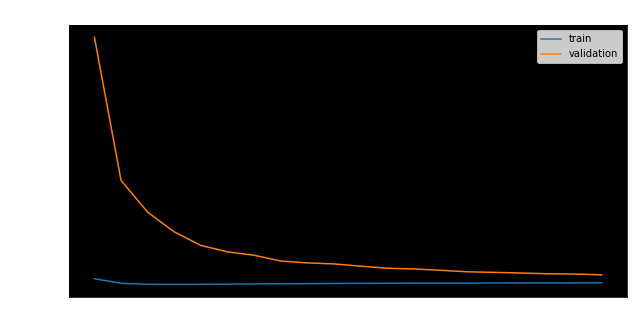

In [40]:

f,ax = plt.subplots(figsize =(10,5))
ax.set_facecolor('black')
ax.set_xlabel(xlabel='Kill Place',color="white")
ax.tick_params(axis='x', colors='white')
ax.set_ylabel(ylabel='Win Place Precentage',color="white")
ax.tick_params(axis='y', colors='white')
sns.lineplot(x=match_nums,y = train_mse_new, label='train')
sns.lineplot(x=match_nums,y = valid_mse_new, label = 'validation')
plt.title('Train & Validation MSE with Different Sample Size', fontsize=15,color='white')
plt.show()

In [192]:
match_nums = [100*i for i in range(1,20)] + [2007]

In [195]:
pred = np.load('predict.npy')

In [197]:
pred.shape

(34167,)